In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os

In [2]:
def get_player_data_from_df(df, column):
    '''
        df: player dataframe;
        column: column to return data from;
    '''
    player_game_ids = list(df['game_id'])
    player_game_ids_idx = 0
    
    player_data = []
    
    for game_id in range(1,83):
        if game_id not in player_game_ids:
            player_data.append(0)
        else:
            player_game_id_data = df[df.game_id == game_id][column].values[0]
            player_data.append(player_game_id_data)
        
    return player_data

def generate_pivoted_player_data_df(df, data):
    '''
        df: player dataframe;
        data: complete data of desired column
    '''
    df_aux = pd.DataFrame()
    df_aux['name'] = [df['name'].values[0]]*82
    df_aux['game_id'] = range(1,83)
    df_aux['data'] = data
    
    pivoted_df = df_aux.pivot("name","game_id","data")
    return pivoted_df
    

In [40]:
def build_df_to_heatmap(data_path):
    '''
        path: path to folder containing data from players
    '''
    
    data_dfs = []
    for fname in os.listdir(data_path):
        df_player = pd.read_csv(data_path+'/'+fname, sep='|')

        player_data = get_player_data_from_df(df_player, 'points')
        player_data = np.array(player_data)
        data_dfs.append(generate_pivoted_player_data_df(df_player, player_data))

    dfs = pd.concat(data_dfs)
    return dfs

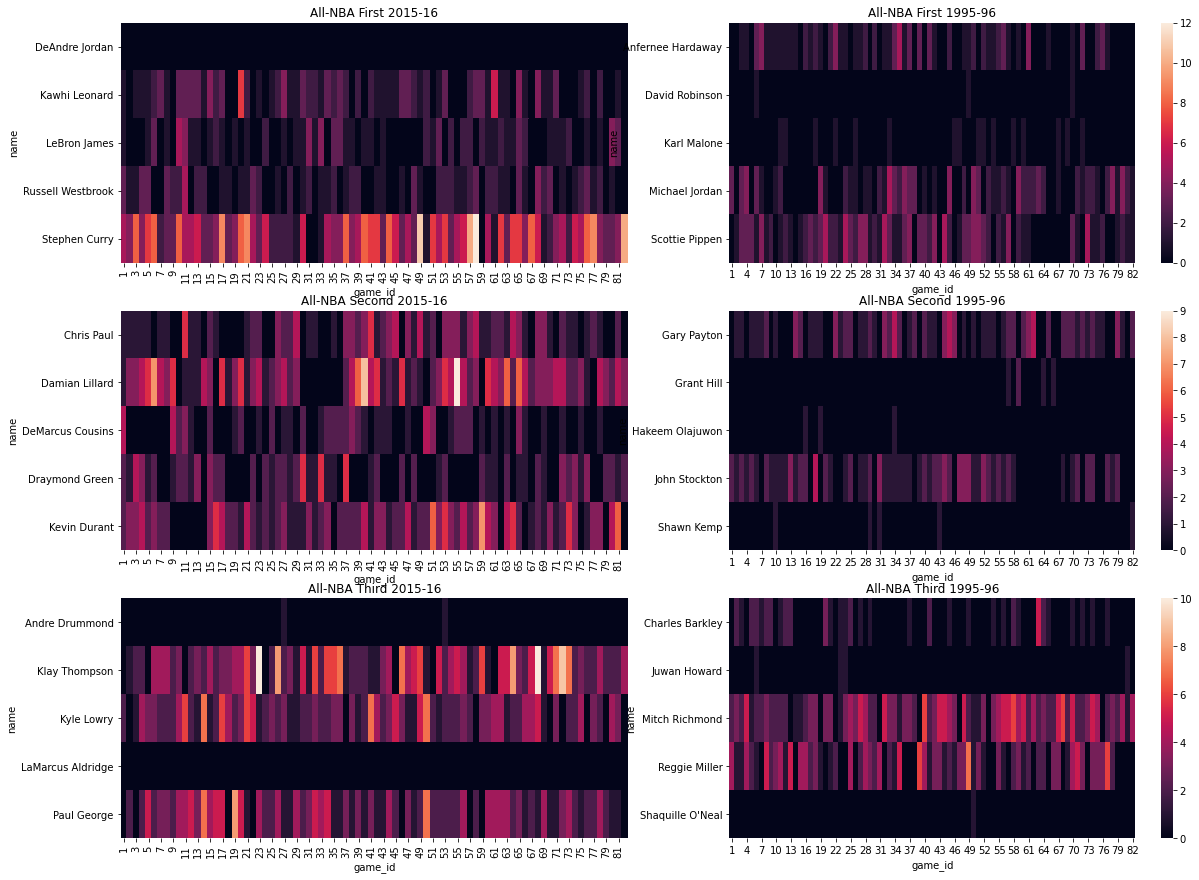

In [38]:
all_nba_fst_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_1516')
all_nba_snd_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_second_1516')
all_nba_trd_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_third_1516')
all_nba_fst_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_9596')
all_nba_snd_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_second_9596')
all_nba_trd_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_third_9596')

f, axs = plt.subplots(3,2,figsize=(20,15))

sb.heatmap(all_nba_fst_1516,ax=axs[0,0],vmin=0,vmax=12,cbar=False)
axs[0,0].title.set_text('All-NBA First 2015-16')
sb.heatmap(all_nba_fst_9596,ax=axs[0,1],vmin=0,vmax=12,cbar=True)
axs[0,1].title.set_text('All-NBA First 1995-96')
sb.heatmap(all_nba_snd_1516,ax=axs[1,0],vmin=0,vmax=9,cbar=False)
axs[1,0].title.set_text('All-NBA Second 2015-16')
sb.heatmap(all_nba_snd_9596,ax=axs[1,1],vmin=0,vmax=9,cbar=True)
axs[1,1].title.set_text('All-NBA Second 1995-96')
sb.heatmap(all_nba_trd_1516,ax=axs[2,0],vmin=0,vmax=10,cbar=False)
axs[2,0].title.set_text('All-NBA Third 2015-16')
sb.heatmap(all_nba_trd_9596,ax=axs[2,1],vmin=0,vmax=10,cbar=True)
axs[2,1].title.set_text('All-NBA Third 1995-96')

plt.show()

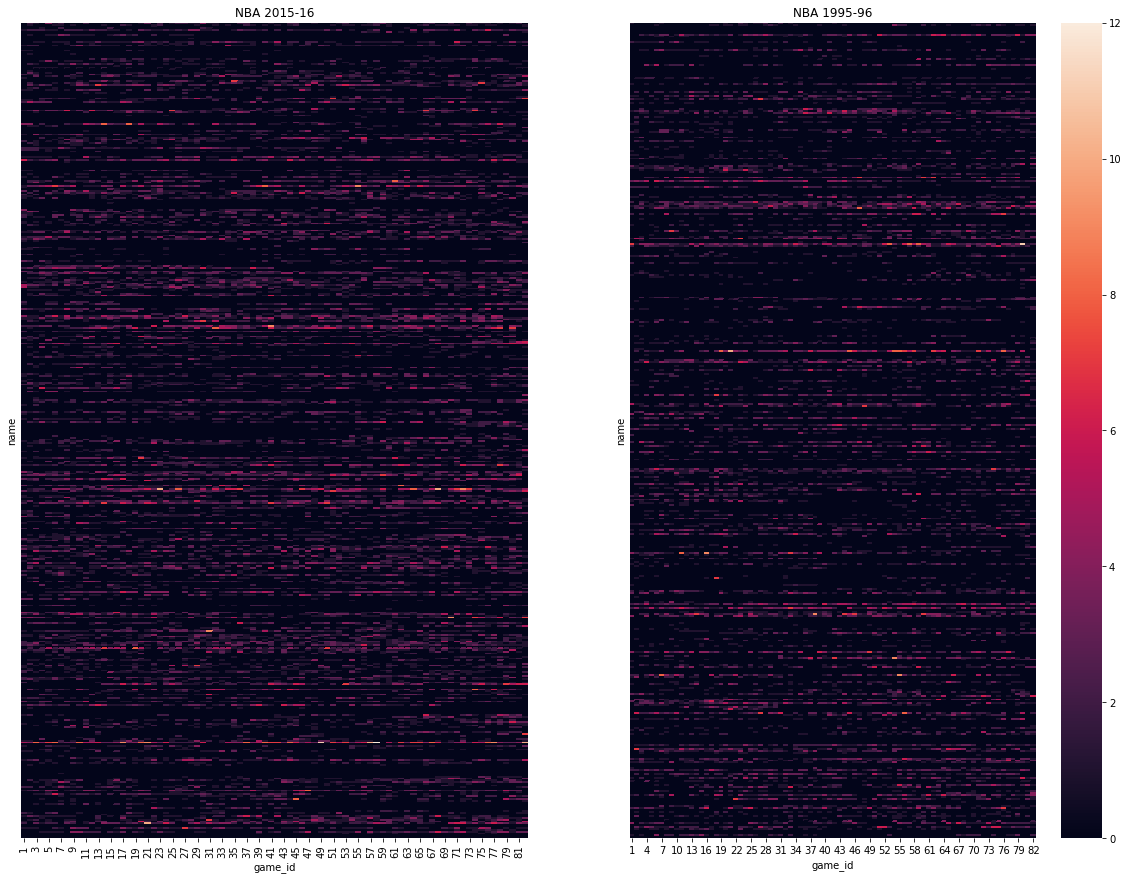

In [39]:
nba_1516 = build_df_to_heatmap(r'../../data/NBA/nba_players_1516')
nba_9596 = build_df_to_heatmap(r'../../data/NBA/nba_players_9596')

f, axs = plt.subplots(1,2,figsize=(20,15))

axs[0].title.set_text('NBA 2015-16')
sb.heatmap(nba_1516,ax=axs[0], yticklabels=[], vmin=0, vmax=12, cbar=False)
axs[1].title.set_text('NBA 1995-96')
sb.heatmap(nba_9596,ax=axs[1], yticklabels=[], vmin=0, vmax=12, cbar=True)

plt.show()

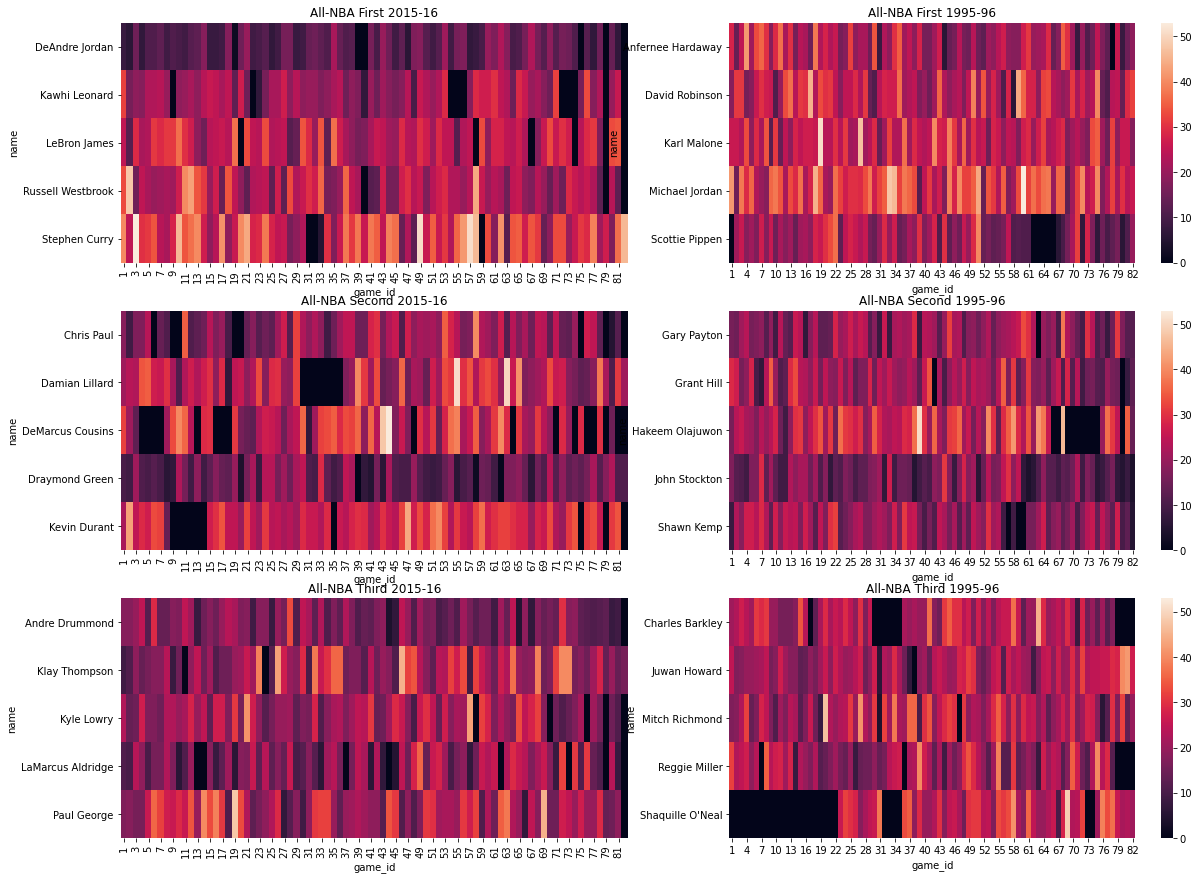

In [42]:
all_nba_fst_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_1516')
all_nba_snd_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_second_1516')
all_nba_trd_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_third_1516')
all_nba_fst_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_9596')
all_nba_snd_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_second_9596')
all_nba_trd_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_third_9596')

f, axs = plt.subplots(3,2,figsize=(20,15))

sb.heatmap(all_nba_fst_1516,ax=axs[0,0],vmin=0,vmax=53,cbar=False)
axs[0,0].title.set_text('All-NBA First 2015-16')
sb.heatmap(all_nba_fst_9596,ax=axs[0,1],vmin=0,vmax=53,cbar=True)
axs[0,1].title.set_text('All-NBA First 1995-96')
sb.heatmap(all_nba_snd_1516,ax=axs[1,0],vmin=0,vmax=53,cbar=False)
axs[1,0].title.set_text('All-NBA Second 2015-16')
sb.heatmap(all_nba_snd_9596,ax=axs[1,1],vmin=0,vmax=53,cbar=True)
axs[1,1].title.set_text('All-NBA Second 1995-96')
sb.heatmap(all_nba_trd_1516,ax=axs[2,0],vmin=0,vmax=53,cbar=False)
axs[2,0].title.set_text('All-NBA Third 2015-16')
sb.heatmap(all_nba_trd_9596,ax=axs[2,1],vmin=0,vmax=53,cbar=True)
axs[2,1].title.set_text('All-NBA Third 1995-96')

plt.show()

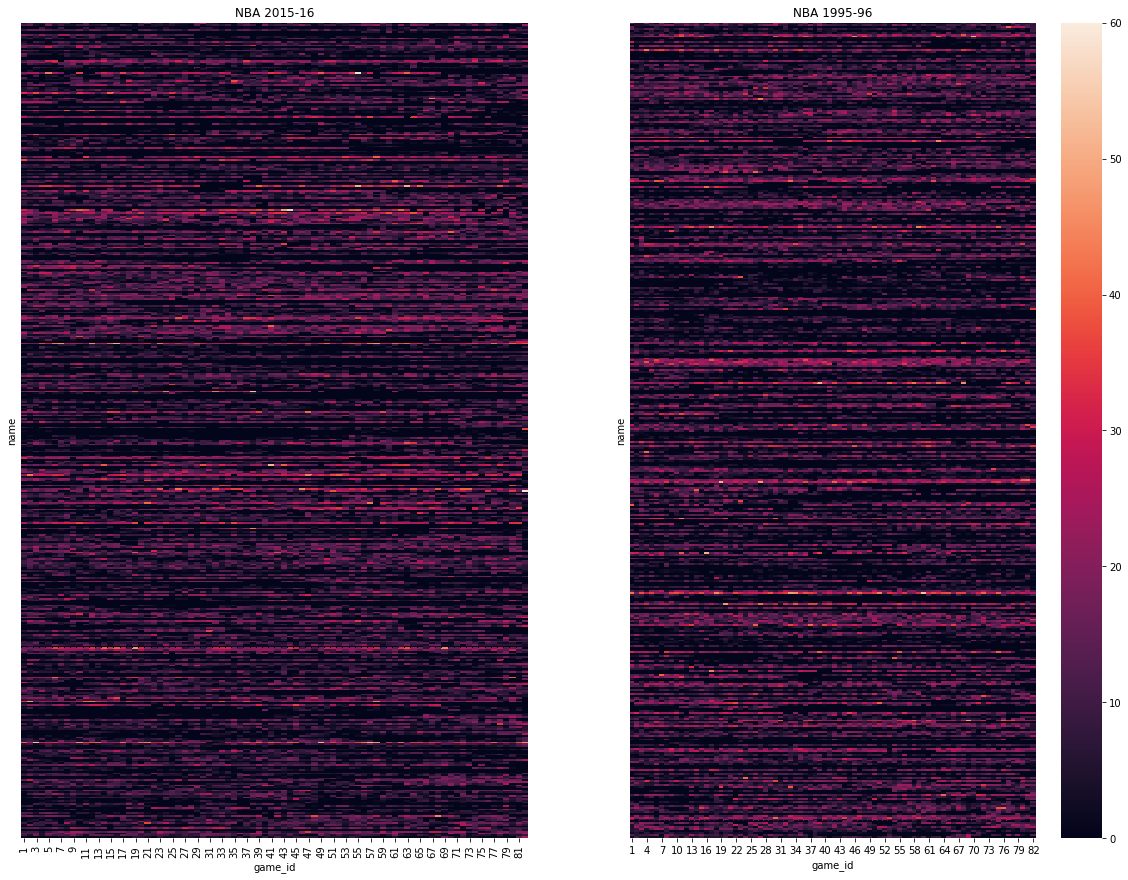

In [43]:
nba_1516 = build_df_to_heatmap(r'../../data/NBA/nba_players_1516')
nba_9596 = build_df_to_heatmap(r'../../data/NBA/nba_players_9596')

f, axs = plt.subplots(1,2,figsize=(20,15))

axs[0].title.set_text('NBA 2015-16')
sb.heatmap(nba_1516,ax=axs[0], yticklabels=[], vmin=0, vmax=60, cbar=False)
axs[1].title.set_text('NBA 1995-96')
sb.heatmap(nba_9596,ax=axs[1], yticklabels=[], vmin=0, vmax=60, cbar=True)

plt.show()